In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas


Using TensorFlow backend.


In [162]:
genres_df = pandas.read_csv('output/movie_genres.csv').set_index('movie')
genres_mat = np.matrix(genres_df.reset_index(drop=True))
genres = genres_df.columns

In [51]:
import os

dim = (100, 100)
channels = 3

poster_ids = []
poster_data = []
posters_dir = 'posters/'
for movie, row in genres_df.iterrows():
    img_path = '{}/{}.jpg'.format(posters_dir, movie)
    img = image.load_img(img_path, target_size=dim, color_mode='rgb')
    x = image.img_to_array(img)
    poster_data.append(x)
    poster_ids.append(movie)
poster_data = np.array(poster_data)
poster_data.shape

(1029, 100, 100, 3)

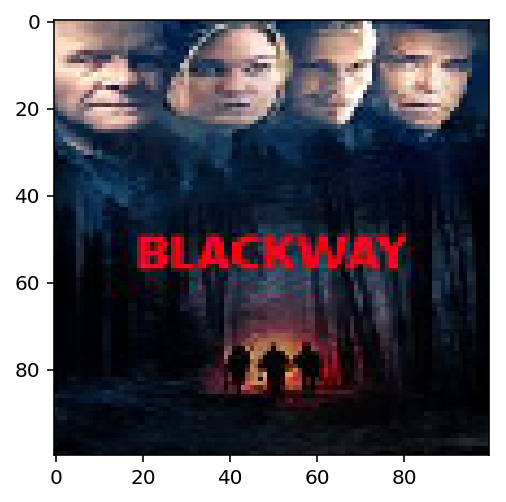

In [54]:
plt.imshow(poster_data[0]/255.)

In [105]:

train_data = poster_data[100:]
test_data = poster_data[0:100]

train_genres = genres_mat[100:]
test_genres = genres_mat[0:100]

x_train = train_data.astype('float32') / 255.
x_test = test_data.astype('float32') / 255.

print "Training Set: %d\n" % len(train_data),
print "Test Set: %d" % len(test_data),

Training Set: 929
Test Set: 100


In [55]:
def get_encoder(input_img):
    x = Conv2D(64, (3, 3), activation='relu', padding='same', 
               input_shape=(dim[0], dim[1], channels))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

def get_decoded(encoded):
    # input dim is the dimension of the encoder (13, 13, 8)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same', input_shape=(dim[0], 
        dim[1], channels), data_format="channels_last")(x)
    return decoded

input_img = Input(shape=(dim[0], dim[1], channels))
encoded = get_encoder(input_img)
decoded = get_decoded(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        9232      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 16)        2320      
_________________________________________________________________
max_

In [58]:
# create encoder
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        9232      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 16)        0         
Total para

In [64]:
encoding_dim = 13, 13, 16

# create decoder, by extracting latter half of the autoencoder's layers
num_encoder_layers = len(encoder.layers)
decoder_layers = len(autoencoder.layers)-num_encoder_layers

encoded_input = Input(shape=encoding_dim)
cur_layer = encoded_input
for l_num in range(decoder_layers):
    cur_layer = autoencoder.layers[num_encoder_layers+l_num](cur_layer)

decoder = Model(encoded_input, cur_layer)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        2320      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 52, 52, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        9280      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 100, 100, 64)      0         
__________

In [166]:
# run 10 epochs of training
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 929 samples, validate on 100 samples
Epoch 1/10
929/929 [==============================] - 28s 31ms/step - loss: 0.5264 - val_loss: 0.5044
Epoch 2/10
929/929 [==============================] - 29s 31ms/step - loss: 0.5044 - val_loss: 0.4954
Epoch 3/10
929/929 [==============================] - 29s 32ms/step - loss: 0.5004 - val_loss: 0.5185
Epoch 4/10
929/929 [==============================] - 30s 33ms/step - loss: 0.4963 - val_loss: 0.5076
Epoch 5/10
929/929 [==============================] - 28s 30ms/step - loss: 0.4944 - val_loss: 0.4906
Epoch 6/10
929/929 [==============================] - 28s 30ms/step - loss: 0.4939 - val_loss: 0.4861
Epoch 7/10
929/929 [==============================] - 30s 32ms/step - loss: 0.4850 - val_loss: 0.5078
Epoch 8/10
929/929 [==============================] - 31s 33ms/step - loss: 0.4867 - val_loss: 0.4816
Epoch 9/10
929/929 [==============================] - 31s 34ms/step - loss: 0.4842 - val_loss: 0.4914
Epoch 10/10
929/929 [===============

In [167]:
# encode and decode test images
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

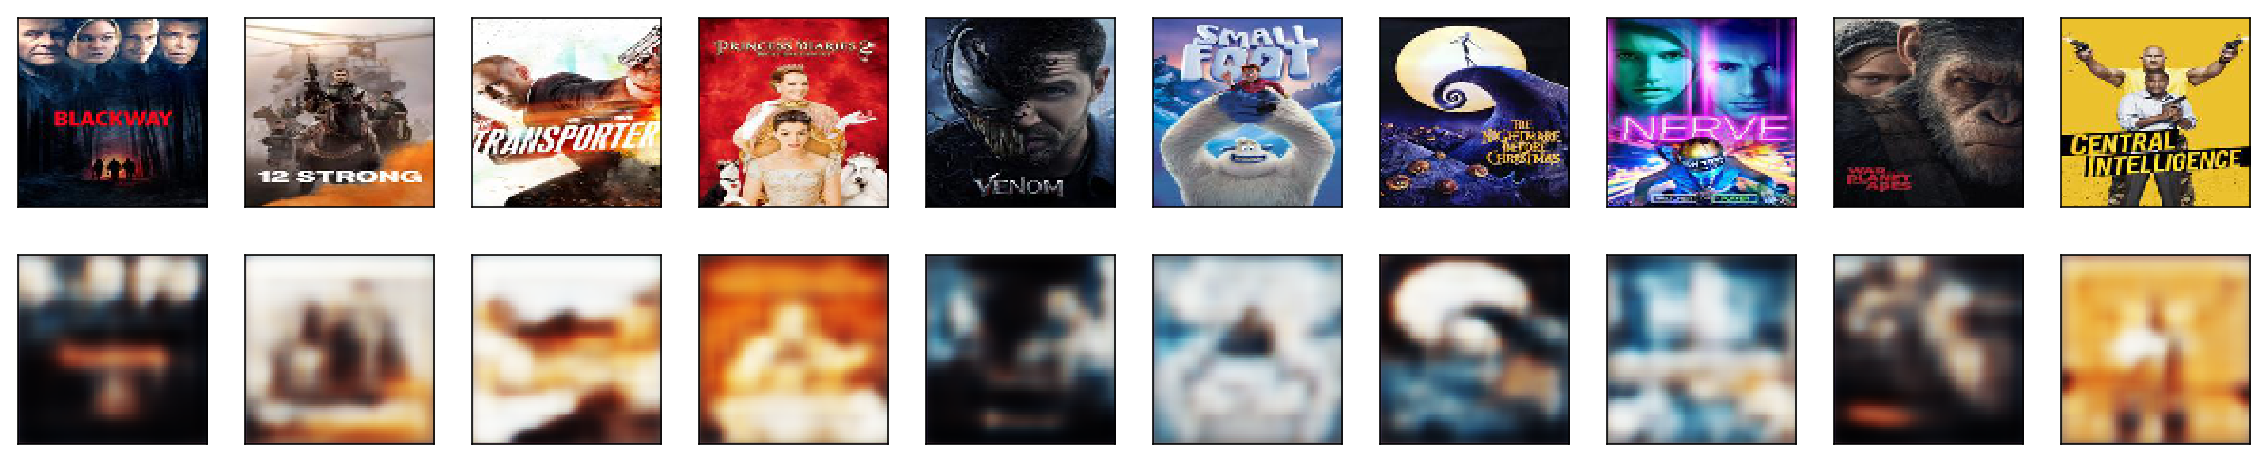

In [168]:

# plot first 10 images and autoencoded representations

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


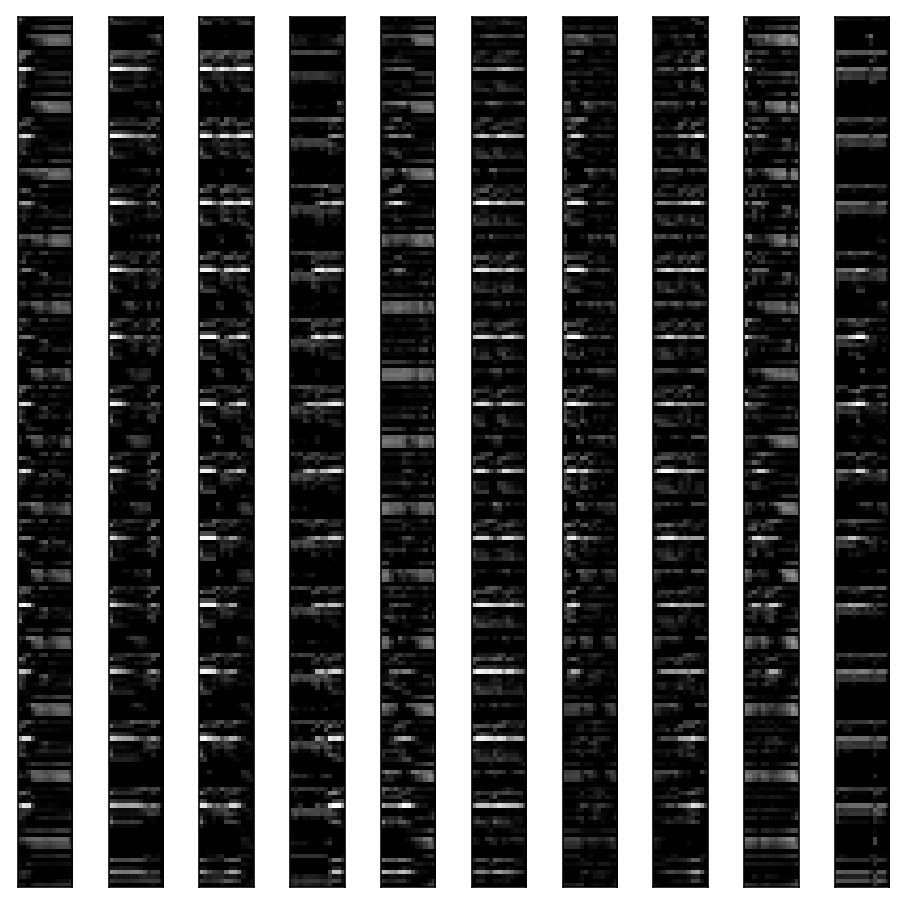

In [169]:
# visualize encodings of the first 10 images

n = 10
plt.figure(figsize=(8, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(13, 13 * 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


(1, 100, 100, 3)

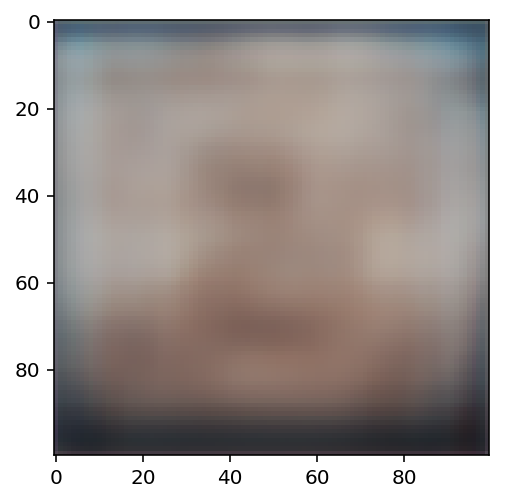

In [170]:
# take a mean encoding of the first 10 images
mean_poster = np.mean(encoded_imgs, axis=0)
mean_poster = np.array([mean_poster])
mean_poster.shape

# what poster does the combined encodings make
mean_poster_prediction = decoder.predict(mean_poster)
plt.imshow(mean_poster_prediction[0])
mean_poster_prediction.shape

In [171]:
encoded_train_imgs = encoder.predict(x_train)

In [182]:
from sklearn.manifold import TSNE

def get_tsne(perplexity):
    perplexity = 10
    tsne = TSNE(n_components=2, random_state=0,perplexity=perplexity)
    shp = encoded_train_imgs.shape
    encoded_reshaped = encoded_train_imgs.reshape((shp[0], shp[1]*shp[2]*shp[3]))
    x_train_2d = tsne.fit_transform(encoded_reshaped)
    return x_train_2d

def plot_tsne(x_train_2d, perplexity):
    plt.figure(figsize=(10, 10))

    plt.title(perplexity)

    for i in np.arange(0, len(x_train_2d), 1):
        x, y = x_train_2d[i]
        img = x_train[i]
        plt.imshow(img, extent=[x-1, x+1, y-1, y+1], aspect=1.5, zorder=2)

    plt.scatter(x_train_2d[:, 0], x_train_2d[:, 1], s=1, zorder=1)
    plt.savefig('tSNE_{}.jpg'.format(perplexity), dpi=300)


In [173]:
perplexity = 20
x_train_2d = get_tsne(perplexity)

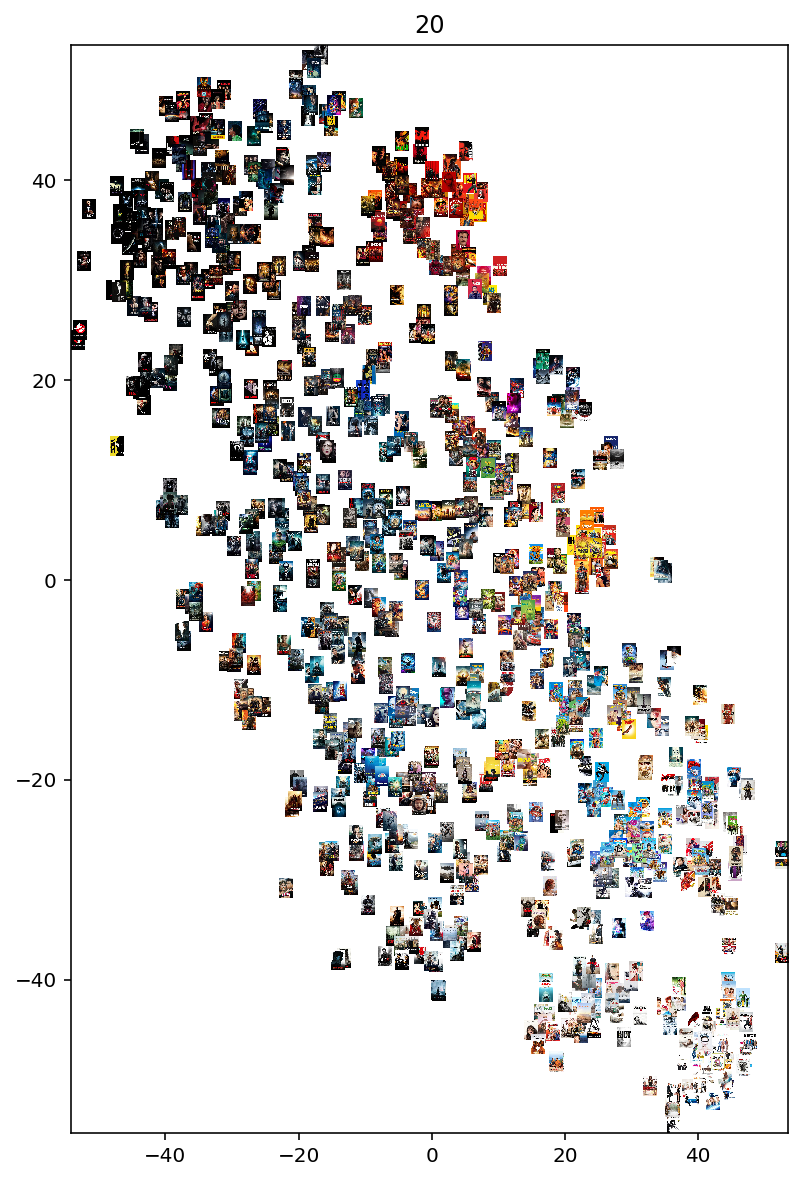

In [183]:
plot_tsne(x_train_2d, perplexity)

In [178]:
genre = 'Horror'

def plot_genre(x_train_2d, genre):
    print genre
    plt.figure(figsize=(6, 6))
    plt.title('Genre: {}'.format(genre))
    plt.scatter(x_train_2d[:, 0], x_train_2d[:, 1], s=20, zorder=1, color='#dfdfdf')
    g_index = np.where(genres == genre)

    action_indices = train_genres[:, g_index].A1.astype(bool)
    action_train_2d = x_train_2d[action_indices, ]
    plt.scatter(action_train_2d[:, 0], action_train_2d[:, 1], s=30, zorder=2)
    plt.savefig('output/{}.jpg'.format(genre), dpi=100)


Action
Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
Fantasy
History
Horror
Music
Mystery
Romance
Science Fiction
TV Movie
Thriller
War
Western


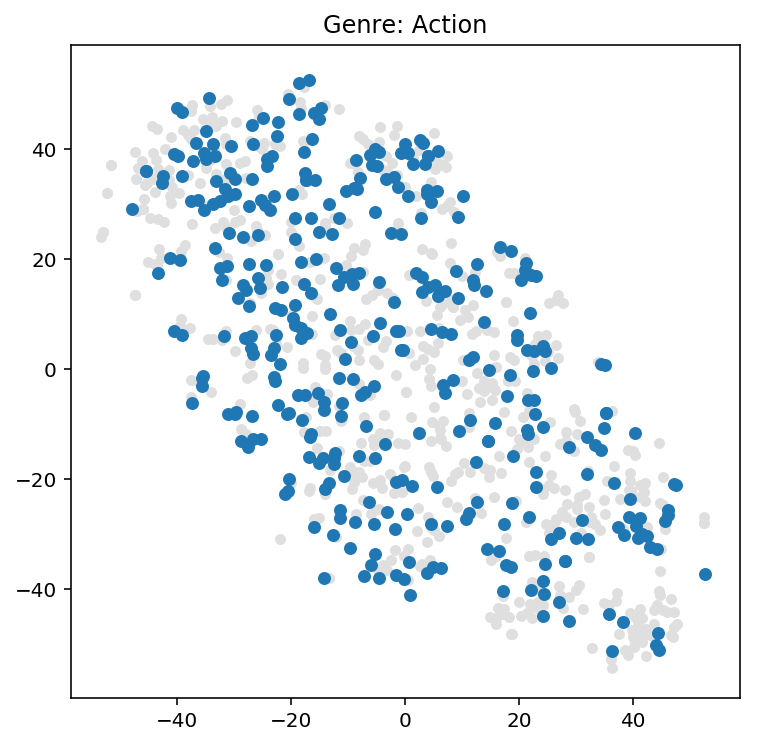

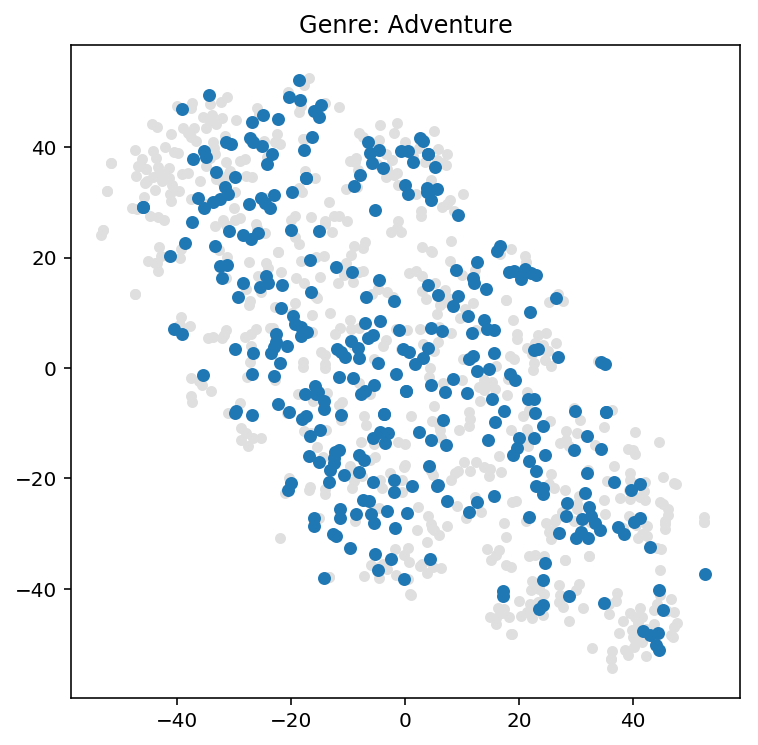

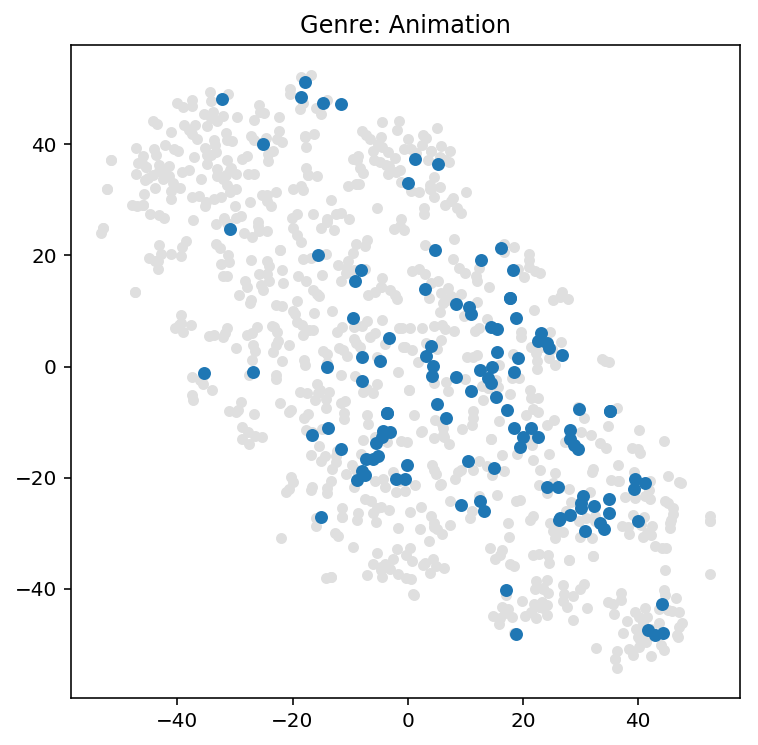

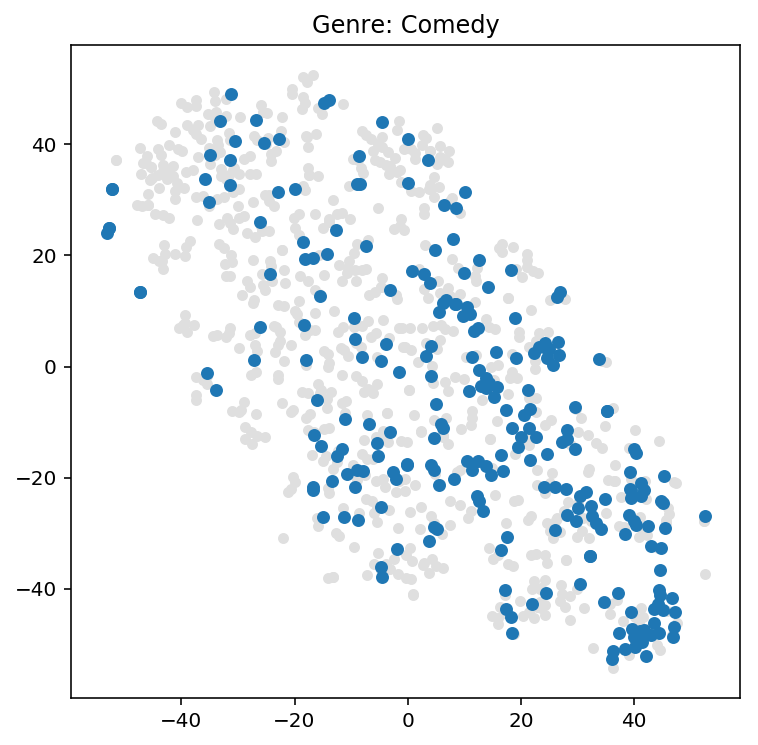

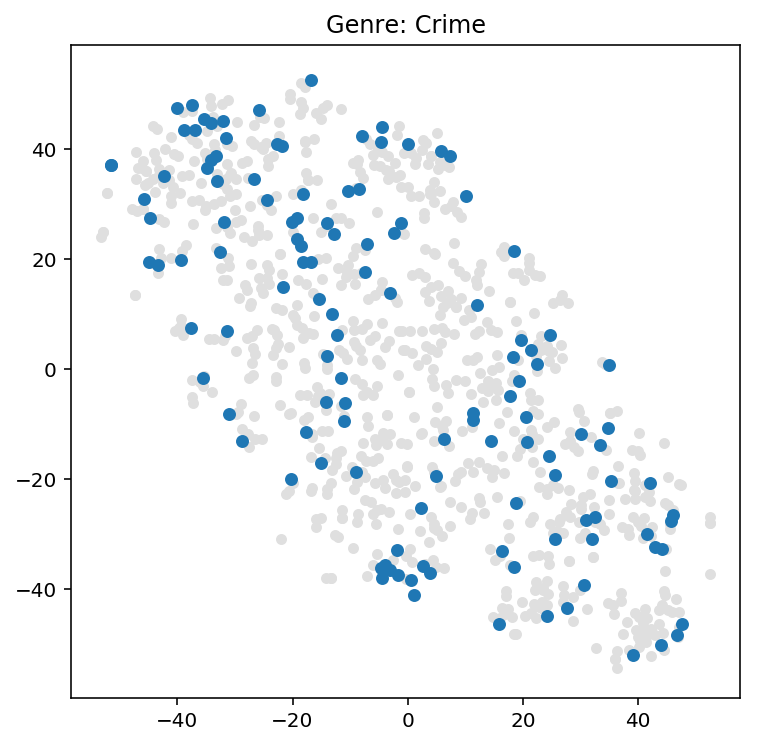

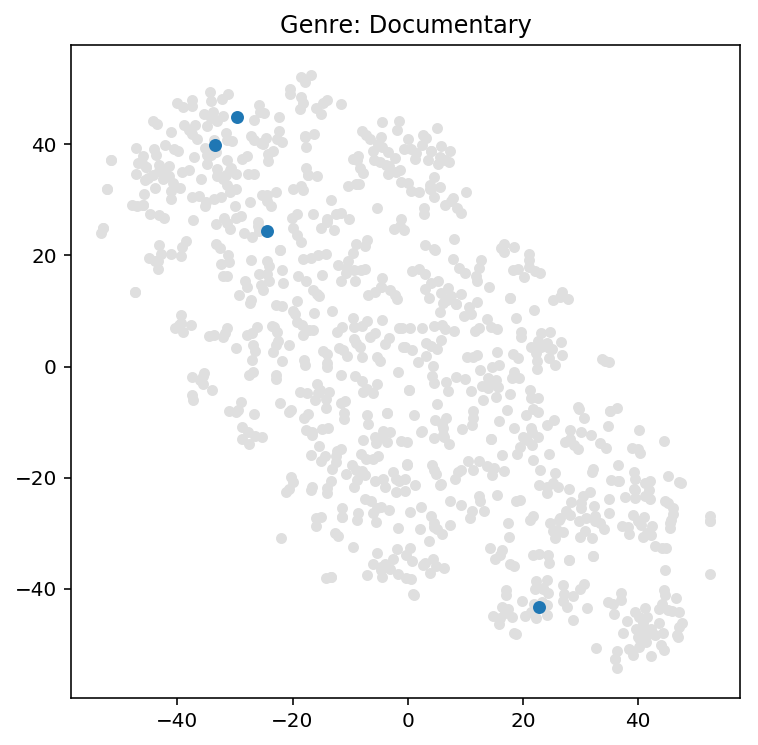

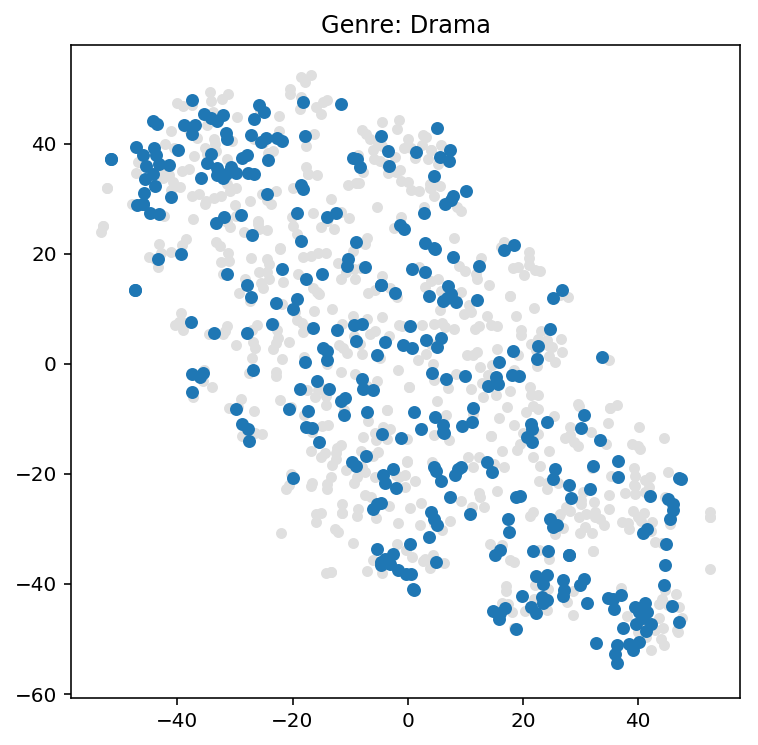

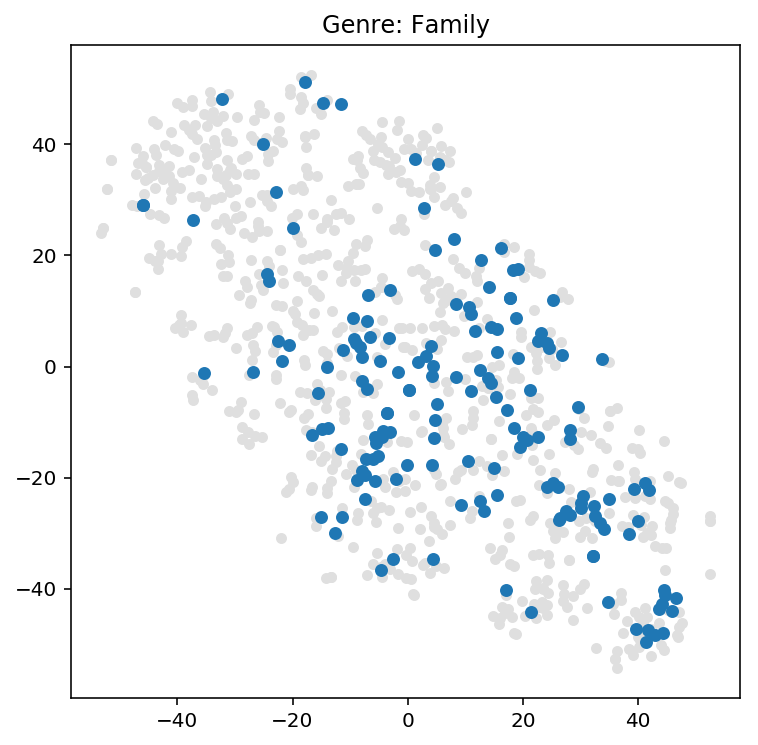

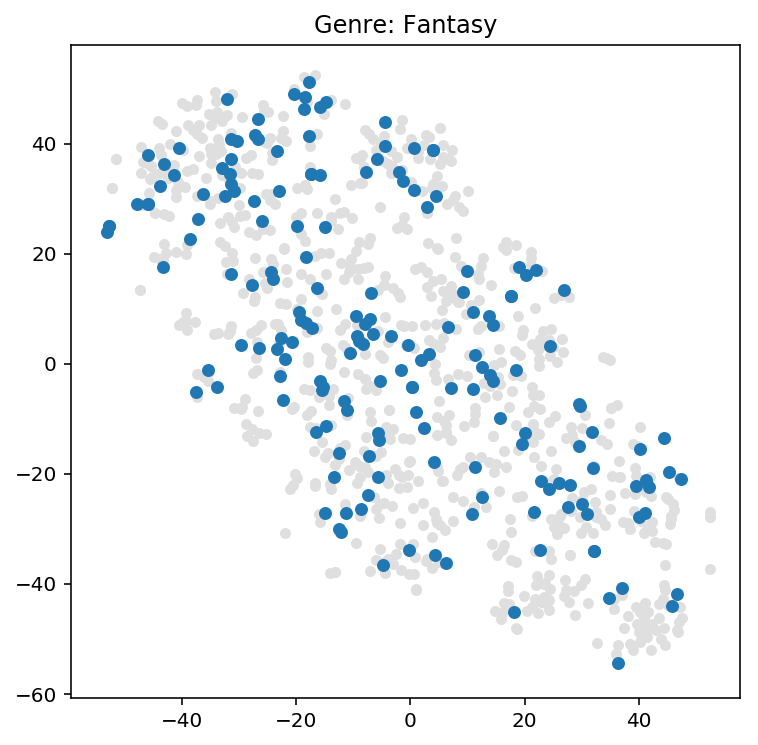

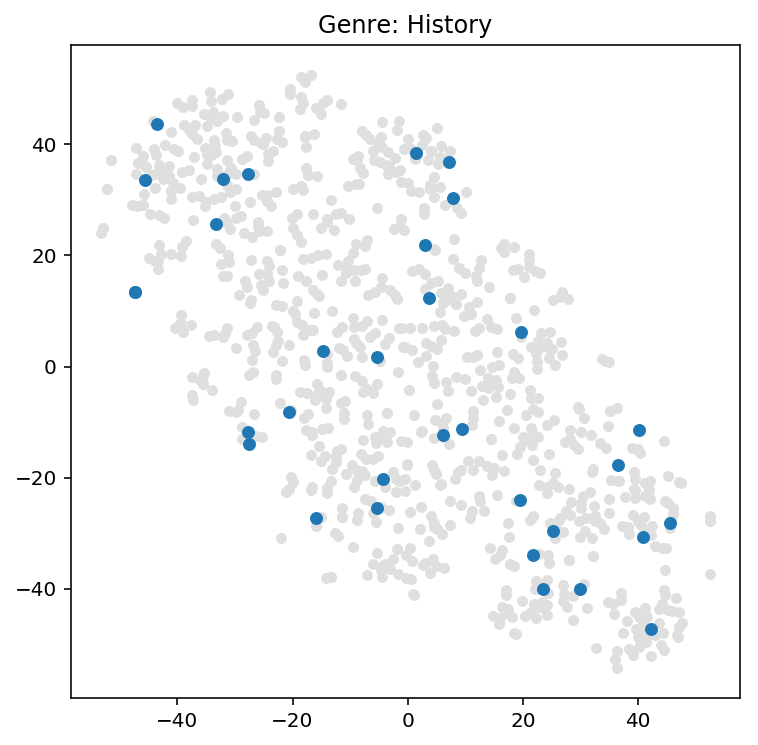

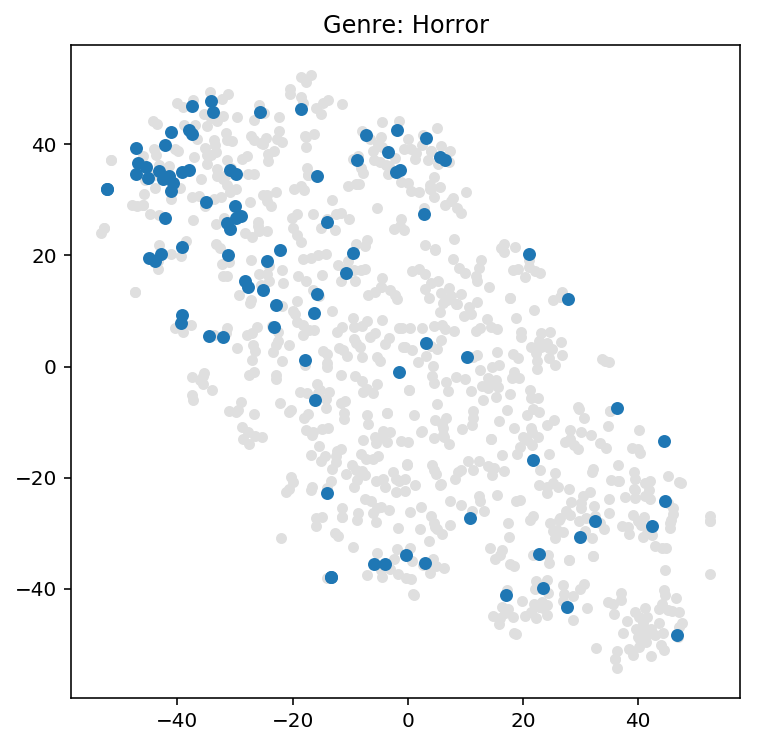

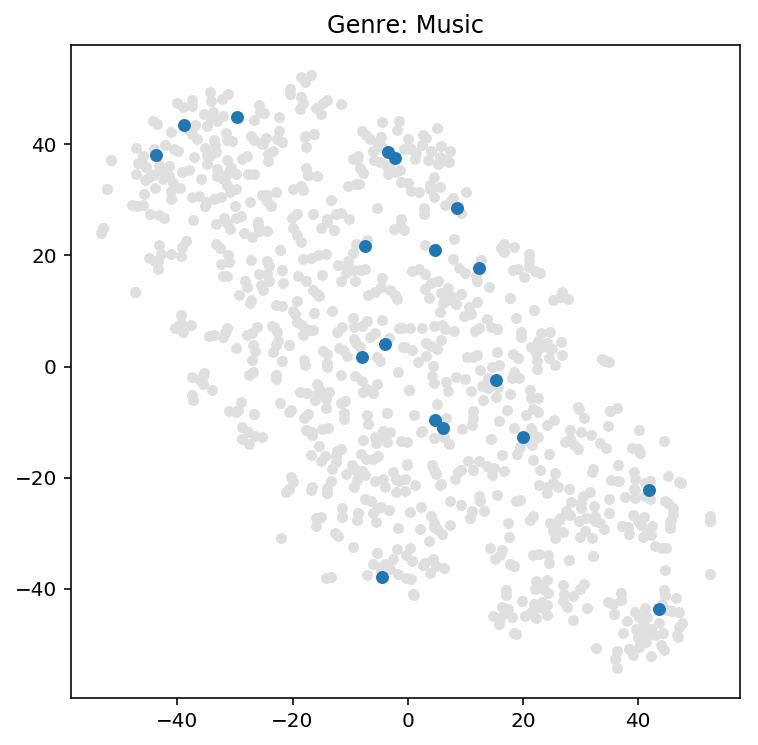

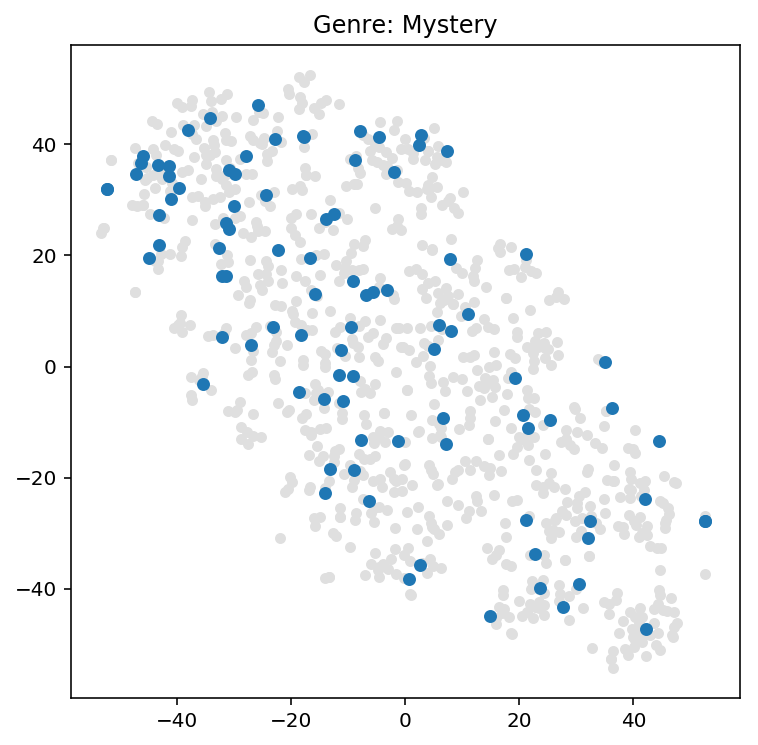

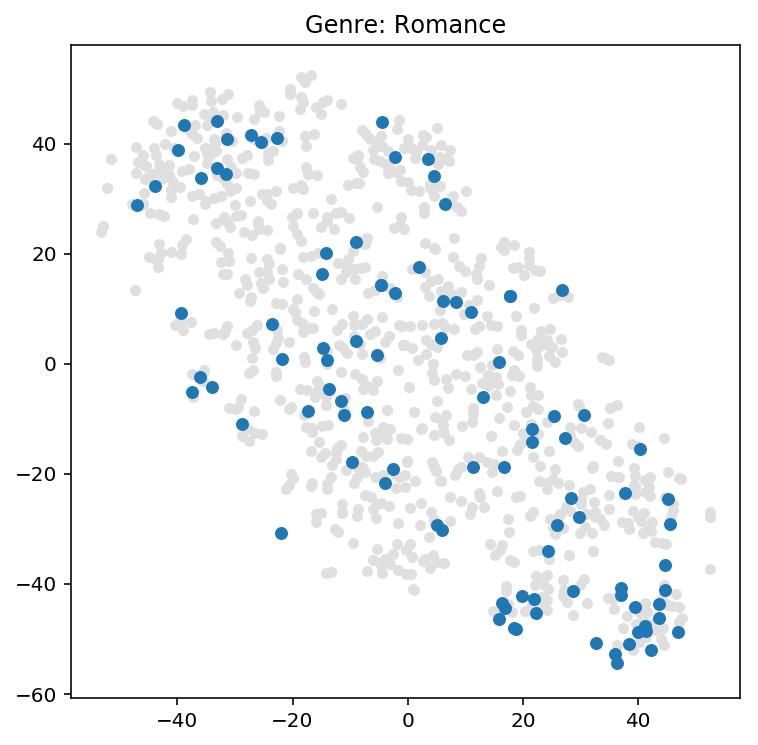

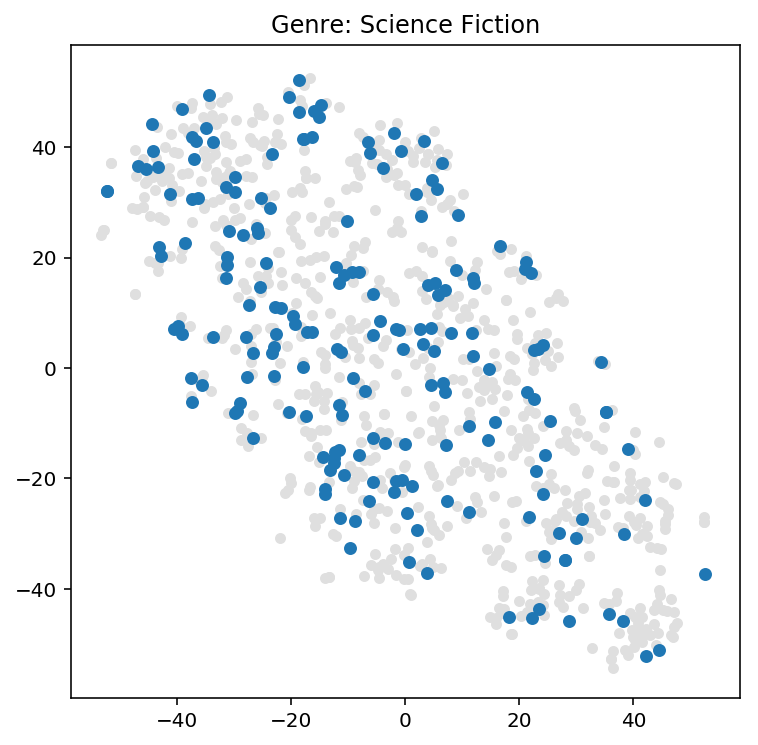

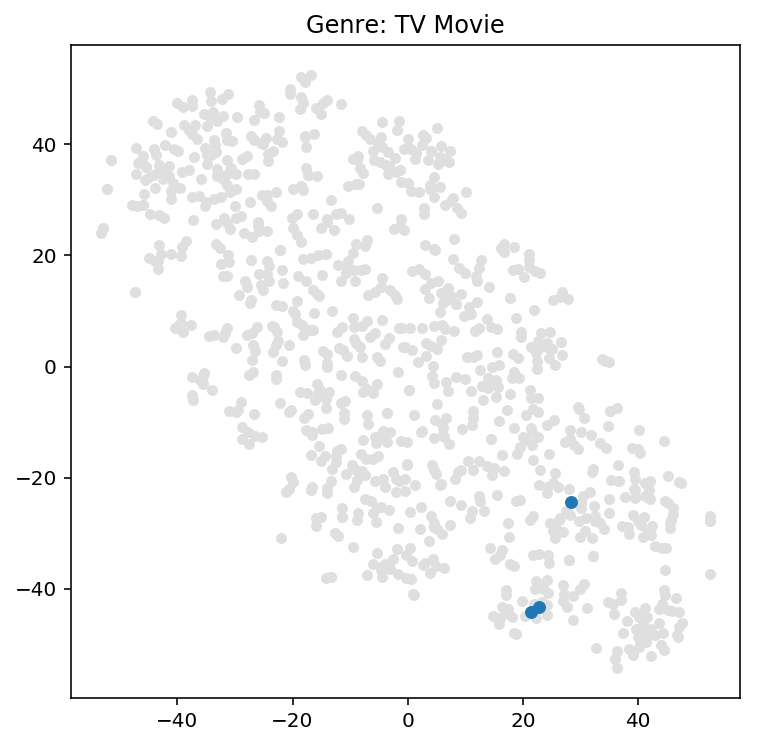

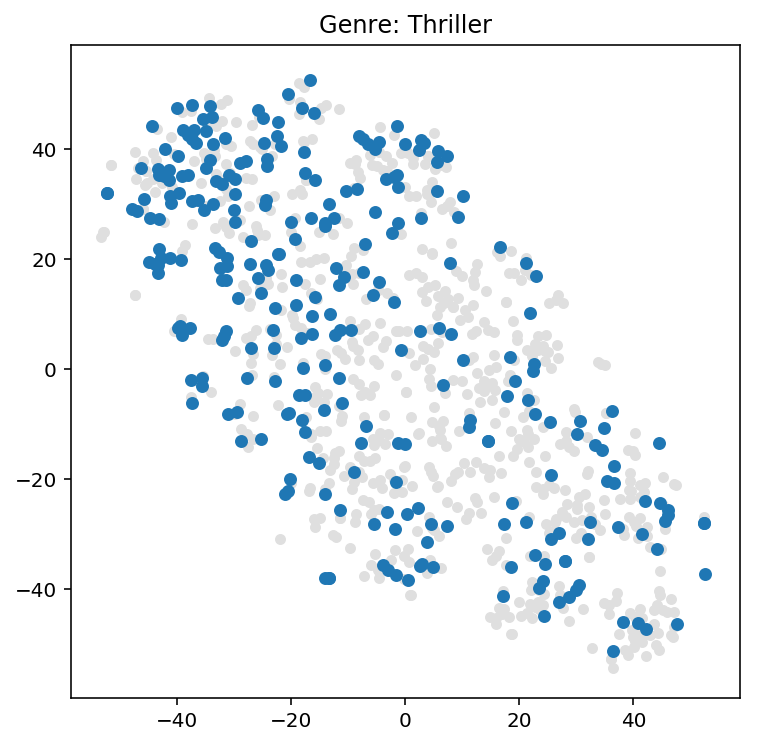

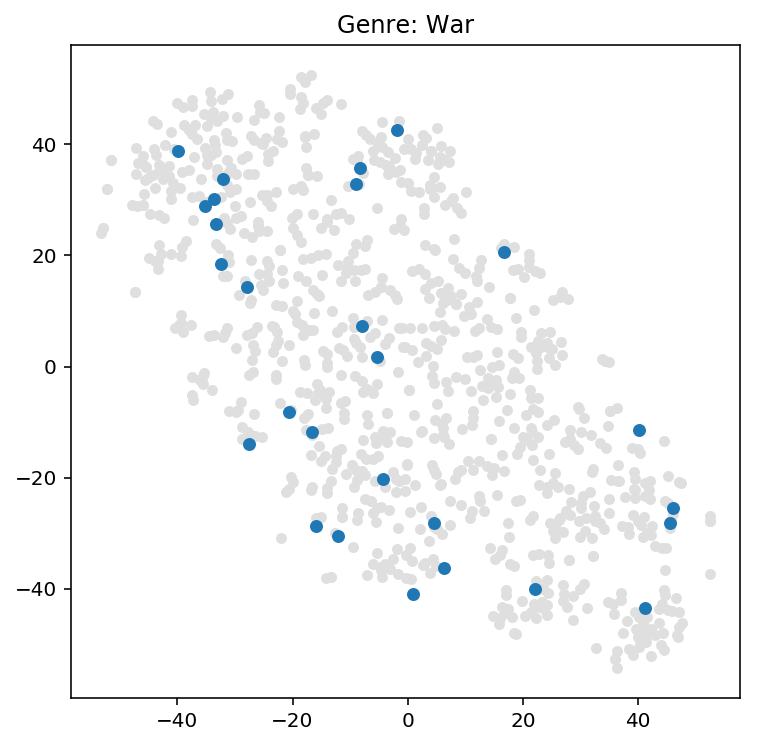

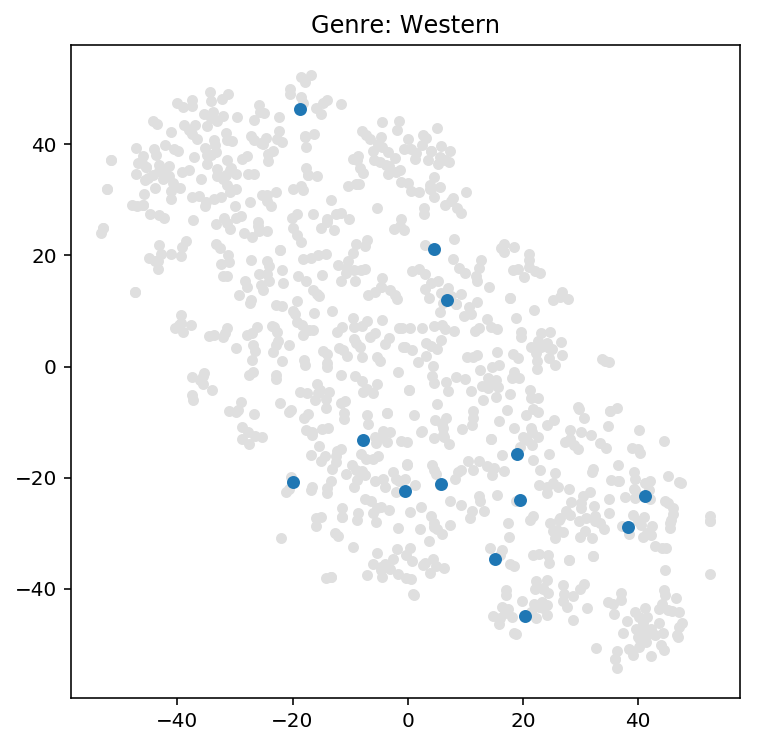

In [179]:
for genre in genres:
    plot_genre(x_train_2d, genre)